In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import savgol_filter
from random import gauss
%matplotlib inline

In [3]:
def NGD(x):
    
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    for j in range(len(T)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [4]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MI=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])
        MI[i]=np.sum(MIsingle)
    return timeshift,MI

In [6]:
def FFT_quick(data):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(x), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

In [7]:
# OU
alpha = 2
beta =  1
K = 20
g = 10

Tot=300
dt=0.001
T=np.arange(dt,Tot,dt)
tau=0.6
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)

In [8]:
# filtering
fc=2
b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, L)

C:\Users\ckchan\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(150, 160)

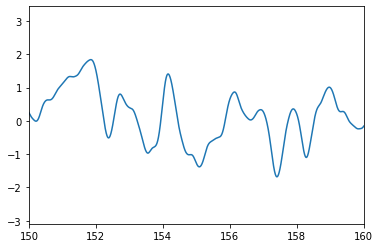

In [9]:
plt.plot(T,x)
plt.xlim(150,160)

(100, 110)

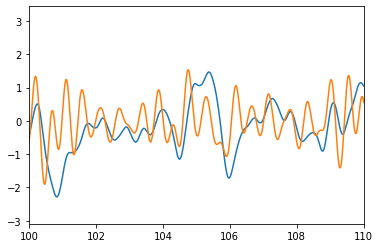

In [11]:
y,z=NGD(x)
plt.plot(T,x)
plt.plot(T,y)
plt.xlim(100,110)

In [12]:
freq,p1,phasex=FFT_quick(x)
freq,p2,phasey=FFT_quick(y)

(0, 3)

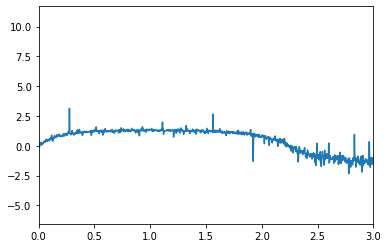

In [13]:
# phase for numerical input
phi=phasey-phasex
for i in range(len(phi)-1):
    if phi[i+1]-phi[i]>math.pi:
        phi[i+1]=phi[i+1]-2*math.pi
    elif phi[i+1]-phi[i]<-math.pi:
        phi[i+1]=phi[i+1]+2*math.pi
plt.plot(freq,phi)
plt.xlim(0,3)

(-1, 1)

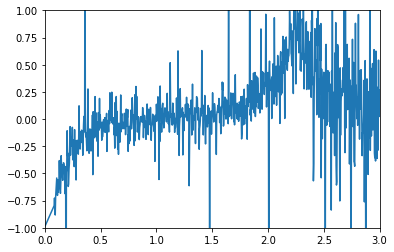

In [14]:
# group for numerical input
df=freq[1]-freq[0]
domega=df*2*math.pi
dphi=np.diff(phi)
delta=-dphi/domega
delta_new=savgol_filter(delta, 51, 1)
plt.plot(freq[0:-1],delta_new)
plt.xlim(0,3)
plt.ylim(-1,1)

In [13]:
# analytic result 

omega=np.linspace(0,30,10000)
A=np.zeros(len(omega))
B=np.zeros(len(omega))
for i in range(len(omega)):
    A[i]=alpha*beta**2+g*beta*K+omega[i]**2*alpha
    B[i]=-omega[i]**3+omega[i]*g*K-beta**2*omega[i]
# phase
phi_ana=np.zeros(len(omega))
for i in range(len(omega)):
    phi_ana[i]=math.atan(B[i]/A[i])
# group
delta_ana=-np.diff(phi_ana)/(omega[1]-omega[0])
# gain
C=np.zeros(len(omega))
for i in range(len(omega)):
    C[i]=(-omega[i]**2+alpha*beta+g*K)**2+(omega[i]*(alpha+beta))**2
gain_ana=K/C*(A**2+B**2)**(1/2)

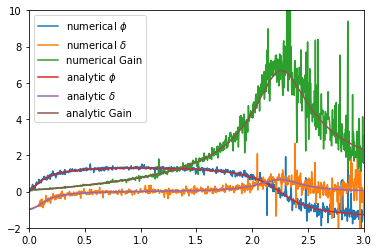

In [14]:
plt.plot(freq,phi)
plt.plot(freq[0:-1],delta_new)
plt.plot(freq,p2/p1)

plt.plot(omega/2/math.pi,phi_ana)
plt.plot(omega[0:-1]/2/math.pi,delta_ana)
plt.plot(omega/2/math.pi,gain_ana)

plt.xlim(0,3)
plt.ylim(-2,10)
plt.legend(('numerical $\phi$','numerical $\delta$','numerical Gain','analytic $\phi$','analytic $\delta$','analytic Gain'))

(0.0, 3.0)

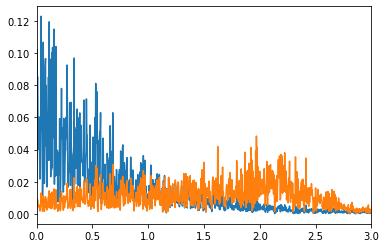

In [15]:
plt.plot(freq,p1)
plt.plot(freq,p2)
plt.xlim(0,3)